Validate graph formating and structure



In [1]:
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader6 import _apply_implicit_or, _compute_hash, _compute_truth_key

from dgd.utils.utils5 import (
    calculate_truth_table_v2,
    generate_one_hot_features_from_adj,
    resize_matrix,
    energy_score,
    check_implicit_OR_existence_v3,
    add_implicit_OR_to_dag_v2,
    exhaustive_cut_enumeration_dag,
    is_fanout_free_standalone,
    generate_subgraph,
    simulate_signal_propagation_binary,
    load_graph_pickle,
    plot_circuit_layered
)

from dgd.utils.verification import *

Done loading action motifs. There are 15928 unique motifs.


In [2]:
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]       
TTABLE_TO_ACTIONS = action_motifs["lookup"]

UNIQUE_GRAPHS

In [3]:
bad, warned = [], []

for idx, G in enumerate(UNIQUE_GRAPHS):
    res = validate_dag(G, n_outputs=1, raise_on_error=False, plot_on_error=True,
                       plot_title=f"Graph {idx} failed")

    # warnings (non-fatal)
    for w in res.get("warnings", []):
        print(f"[{idx}] WARNING: {w}")
    if res.get("warnings"):
        warned.append((idx, res["warnings"]))

    # errors (fatal for this graph)
    if not res["ok"]:
        print(f"[{idx}] ERROR: " + " | ".join(res["errors"]))
        bad.append((idx, res))

print(f"Checked {len(UNIQUE_GRAPHS)} graphs. "
      f"Failed: {len(bad)} | With warnings: {len(warned)}")


[3] WARNING: Inputs are not labeled consecutively as 0..0; found [3]
Checked 15928 graphs. Failed: 0 | With warnings: 1


In [10]:
test_graph = UNIQUE_GRAPHS[10000]
for node in test_graph.nodes(data = True):
    print(node)

(0, {'type': 'input'})
(1, {'type': 'input'})
(2, {'type': 'input'})
(3, {'type': 'input'})
(4, {'type': 'output'})
(5, {})
(6, {})
(7, {})
(8, {})
(9, {})
(10, {})
(11, {})
(12, {})
(13, {})
(14, {})
(15, {})
(16, {})
(17, {})
(18, {})


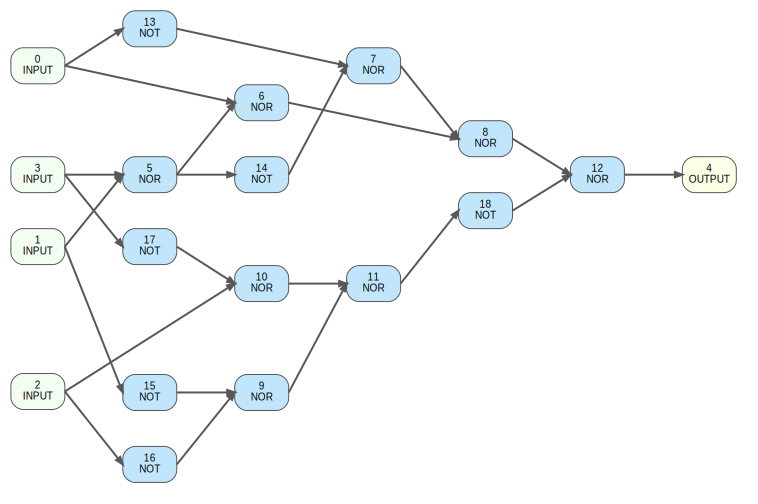

PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/tests/circuit_plot/circuit.svg')

In [11]:
plot_circuit_layered(test_graph, show_in_notebook=True)

NIGs 3 input dataset

In [12]:
import os, re, pickle, networkx as nx
from tqdm.auto import tqdm
from collections import Counter

# ---------------------------------------------------------------------
# 0) Configuration
# ---------------------------------------------------------------------
NIG_DIR = ("/home/gridsan/spalacios/Designing complex biological circuits "
           "with deep neural networks/dgd/data/NIGs_3_inputs/")
hex_re = re.compile(r"0x([0-9a-fA-F]+)")
N_OUTPUTS = 1
PLOT_ON_ERROR = False  # True = show plots for failing graphs (may block)
TREAT_WARNINGS_AS_ERRORS = False

ok_files, failed, warnings_list = [], [], []
pkl_files = sorted([f for f in os.listdir(NIG_DIR) if f.endswith(".pkl")])

for fname in tqdm(pkl_files, desc="Validating DAGs"):
    m = hex_re.match(fname)
    if not m:
        tqdm.write(f"skipped (no 0xHEX_ prefix): {fname}")
        continue

    fpath = os.path.join(NIG_DIR, fname)

    try:
        G = load_graph_pickle(fpath)
    except Exception as e:
        failed.append((fname, [f"load error: {e}"]))
        tqdm.write(f"[{fname}] load error: {e}")
        continue

    try:
        res = validate_dag(
            G,
            n_outputs=N_OUTPUTS,
            raise_on_error=False,
            plot_on_error=PLOT_ON_ERROR,
            plot_title=f"{fname} (validation failed)",
        )
    except Exception as e:
        failed.append((fname, [f"validate_dag exception: {e}"]))
        tqdm.write(f"[{fname}] validate_dag exception: {e}")
        continue

    # --- warnings (non-fatal unless toggled) ---
    ws = res.get("warnings", [])
    if ws:
        warnings_list.append((fname, ws))
        tqdm.write(f"[{fname}] WARNING: " + " | ".join(ws))

    # --- errors (or escalate warnings if configured) ---
    has_error = not res["ok"]
    if has_error or (TREAT_WARNINGS_AS_ERRORS and ws):
        reasons = res.get("errors", [])
        if TREAT_WARNINGS_AS_ERRORS and ws:
            reasons = reasons + [f"(warning) {w}" for w in ws]
        failed.append((fname, reasons))
        if reasons:
            tqdm.write(f"[{fname}] " + " | ".join(reasons))
    else:
        ok_files.append(fname)

# ---------------------------------------------------------------------
# 3) Summary
# ---------------------------------------------------------------------
print("\nSummary")
print(f"  .pkl files scanned: {len(pkl_files)}")
print(f"  Valid DAGs (no errors): {len(ok_files)}")
print(f"  Invalid DAGs:           {len(failed)}")
print(f"  Files with warnings:    {len(warnings_list)}")

Validating DAGs:   0%|          | 0/254 [00:00<?, ?it/s]

skipped (no 0xHEX_ prefix): NIGs_unoptimized_library_3_input_1_output.pkl

Summary
  .pkl files scanned: 254
  Valid DAGs (no errors): 253
  Invalid DAGs:           0
  Files with warnings:    0


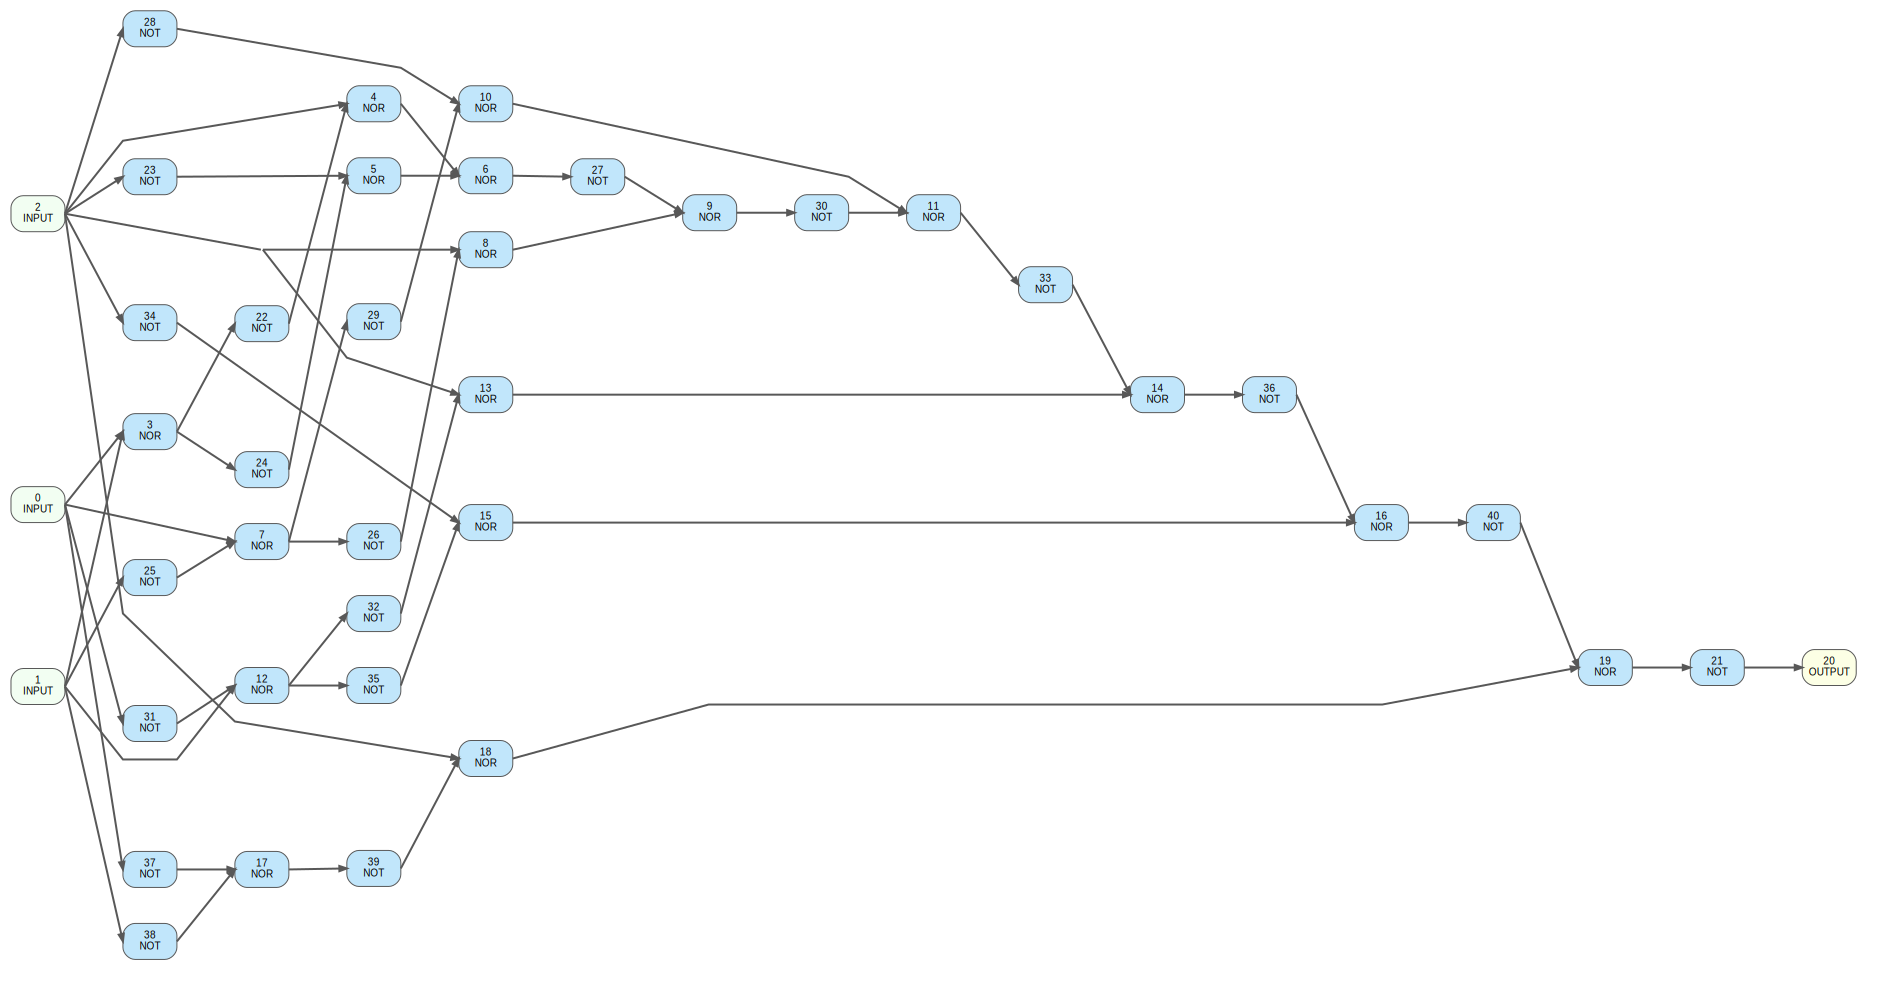

PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/tests/circuit_plot/circuit.svg')

In [13]:
plot_circuit_layered(G, show_in_notebook=True)

NIGs 4 input dataset

In [14]:
import os, re, pickle, networkx as nx
from tqdm.auto import tqdm
from collections import Counter

# ---------------------------------------------------------------------
# 0) Configuration
# ---------------------------------------------------------------------
NIG_DIR = ("/home/gridsan/spalacios/Designing complex biological circuits "
           "with deep neural networks/dgd/data/NIGs_4_inputs/")
hex_re = re.compile(r"0x([0-9a-fA-F]+)")
N_OUTPUTS = 1
PLOT_ON_ERROR = False  # True = show plots for failing graphs (may block)
TREAT_WARNINGS_AS_ERRORS = False

ok_files, failed, warnings_list = [], [], []
pkl_files = sorted([f for f in os.listdir(NIG_DIR) if f.endswith(".pkl")])

for fname in tqdm(pkl_files, desc="Validating DAGs"):
    m = hex_re.match(fname)
    if not m:
        tqdm.write(f"skipped (no 0xHEX_ prefix): {fname}")
        continue

    fpath = os.path.join(NIG_DIR, fname)

    try:
        G = load_graph_pickle(fpath)
    except Exception as e:
        failed.append((fname, [f"load error: {e}"]))
        tqdm.write(f"[{fname}] load error: {e}")
        continue

    try:
        res = validate_dag(
            G,
            n_outputs=N_OUTPUTS,
            raise_on_error=False,
            plot_on_error=PLOT_ON_ERROR,
            plot_title=f"{fname} (validation failed)",
        )
    except Exception as e:
        failed.append((fname, [f"validate_dag exception: {e}"]))
        tqdm.write(f"[{fname}] validate_dag exception: {e}")
        continue

    # --- warnings (non-fatal unless toggled) ---
    ws = res.get("warnings", [])
    if ws:
        warnings_list.append((fname, ws))
        tqdm.write(f"[{fname}] WARNING: " + " | ".join(ws))

    # --- errors (or escalate warnings if configured) ---
    has_error = not res["ok"]
    if has_error or (TREAT_WARNINGS_AS_ERRORS and ws):
        reasons = res.get("errors", [])
        if TREAT_WARNINGS_AS_ERRORS and ws:
            reasons = reasons + [f"(warning) {w}" for w in ws]
        failed.append((fname, reasons))
        if reasons:
            tqdm.write(f"[{fname}] " + " | ".join(reasons))
    else:
        ok_files.append(fname)

# ---------------------------------------------------------------------
# 3) Summary
# ---------------------------------------------------------------------
print("\nSummary")
print(f"  .pkl files scanned: {len(pkl_files)}")
print(f"  Valid DAGs (no errors): {len(ok_files)}")
print(f"  Invalid DAGs:           {len(failed)}")
print(f"  Files with warnings:    {len(warnings_list)}")

Validating DAGs:   0%|          | 0/65540 [00:00<?, ?it/s]


Summary
  .pkl files scanned: 65540
  Valid DAGs (no errors): 65540
  Invalid DAGs:           0
  Files with warnings:    0


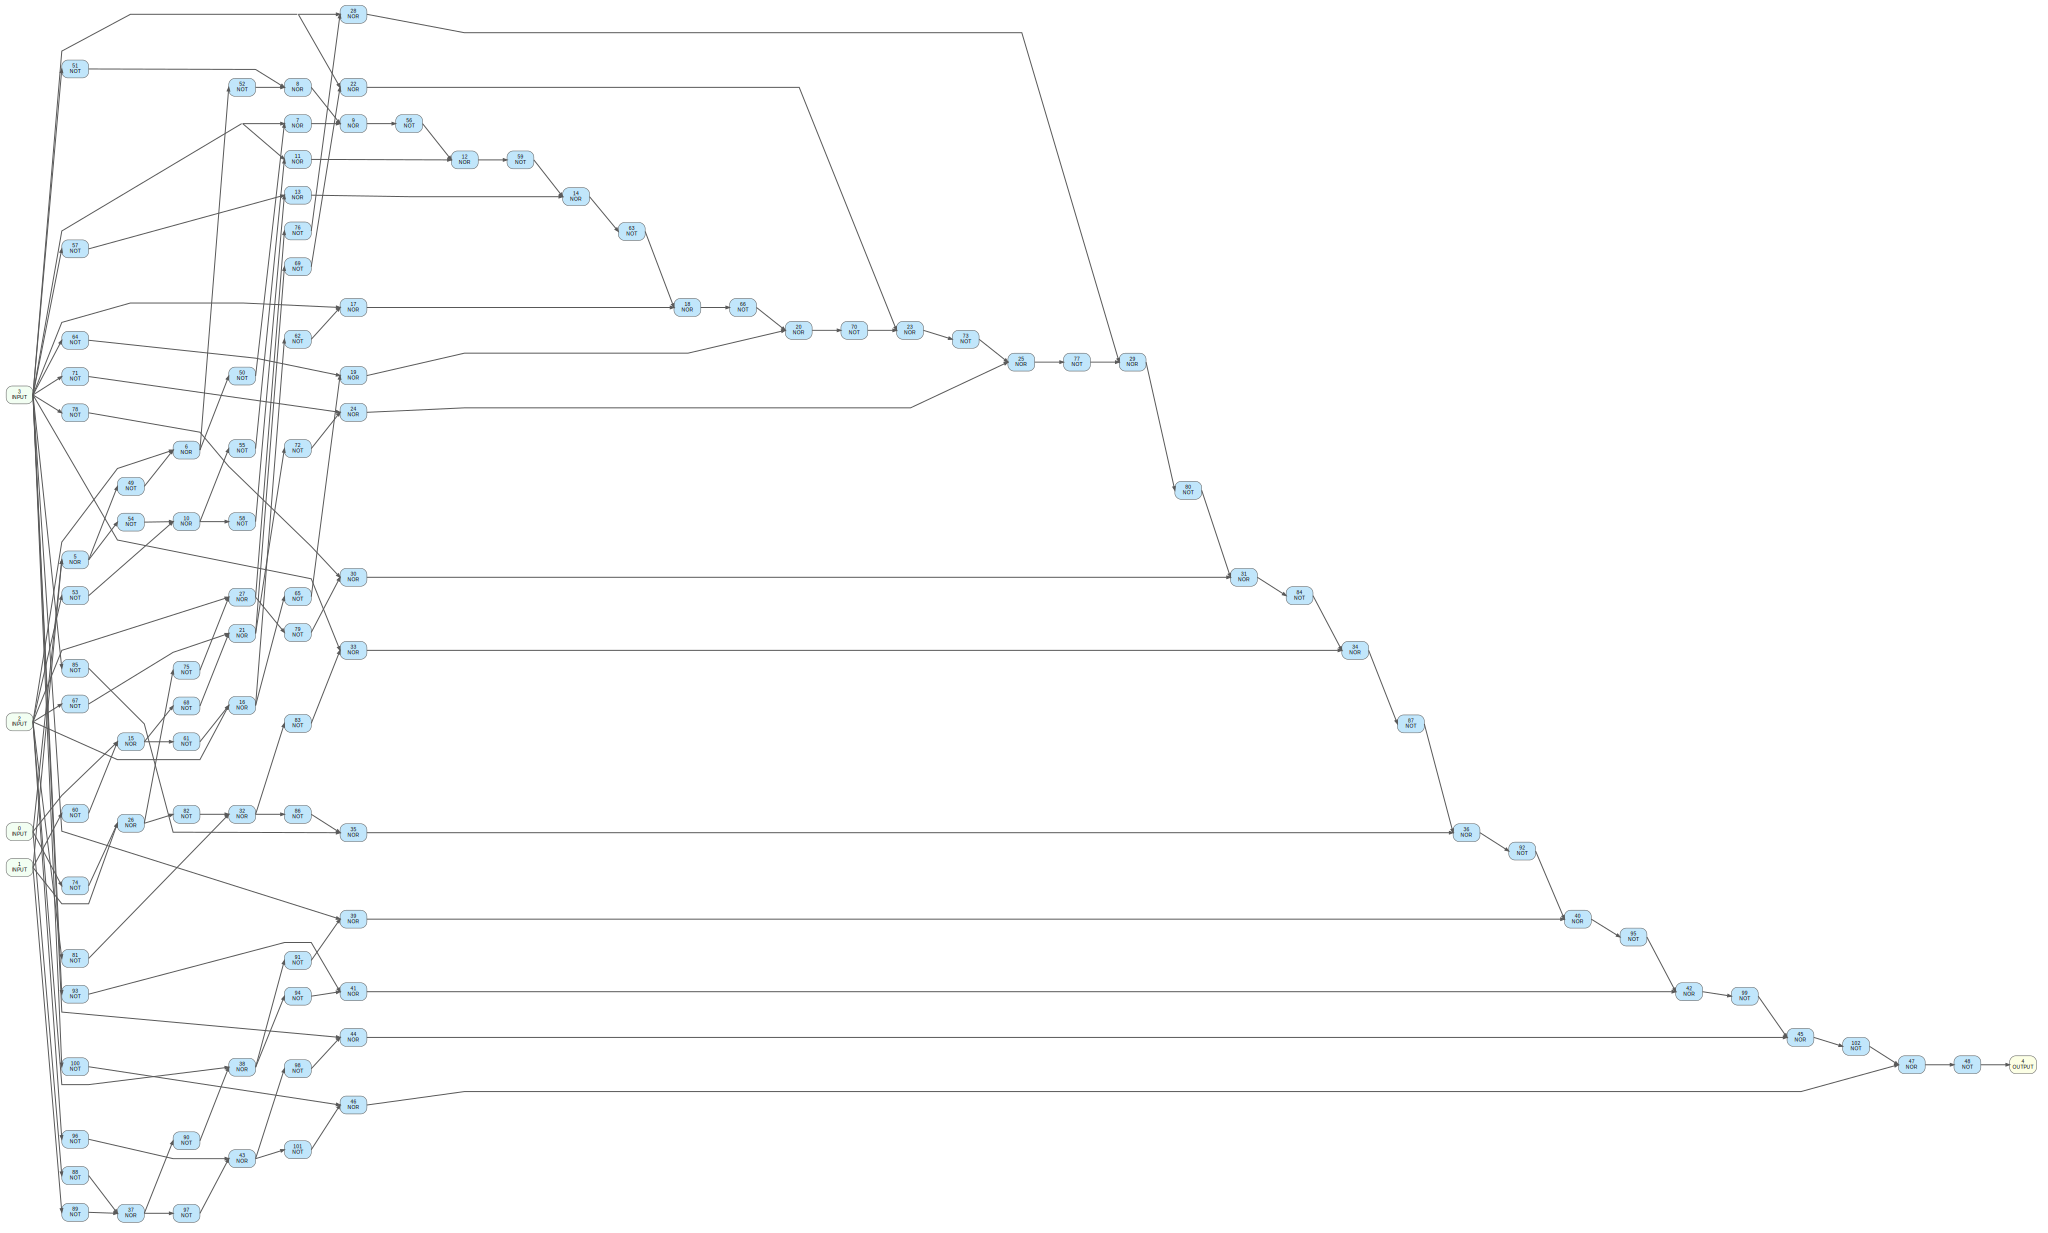

PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/tests/circuit_plot/circuit.svg')

In [15]:
plot_circuit_layered(G, show_in_notebook=True)